# Load DeepFly3D Data

In [106]:
%load_ext autoreload
%autoreload 2
from load import *
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
from liftpose.vision_3d import transform_frame
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

# decleare data parameters
par_train = {'data_dir' : '/data/LiftPose3D/fly_tether/data_DF3D', # change the path 
       'out_dir'        : './out',
       'train_subjects' : [1],
       'test_subjects'  : [6,7],
       'actions'        : ['all'],
       'cam_id'         : [2,5]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# Load 2D data
train_2d = load_2D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)
test_2d = load_2D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

# Load 3D data
train_3d, _, rcams_train = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)
test_3d, _, rcams_test = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

train_3d = transform_frame(train_3d, rcams_train)
test_3d = transform_frame(test_3d, rcams_test)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train LiftPose3D Network on DeepFly3D Data

In [107]:
from liftpose.main import train as lp3d_train

lp3d_train(train_2d=train_2d, test_2d=test_2d, train_3d=train_3d, test_3d=test_3d, 
           **{k:par[k] for k in ['roots', 'target_sets', 'out_dir']})

[main.py:89]:INFO:Saving pre-processed 2D data at /home/user/Desktop/LiftPose3D/examples/fly_tether/out/stat_2d.pth.tar.
[main.py:111]:INFO:Saving pre-processed 3D data at /home/user/Desktop/LiftPose3D/examples/fly_tether/out/stat_3d.pth.tar.
[main.py:138]:INFO:Starting training model
[main.py:147]:DEBUG:
==================Options=================
[main.py:148]:DEBUG:{   'batch_size': 64,
    'data_dir': '/home/user/Desktop/LiftPose3D/examples/fly_tether/out',
    'dropout': 0.5,
    'epochs': 10,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 100000,
    'lr_gamma': 0.96,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/home/user/Desktop/LiftPose3D/examples/fly_tether/out',
    'out_dir': '/home/user/Desktop/LiftPose3D/examples/fly_tether/out',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:149]:DEBUG:================================

Epoch 0 | Loss Test 0 | Loss Train 0.30954|: 100%|█████████▉| 3288/3291 [00:42<00:00, 78.78it/s]

KeyboardInterrupt: 

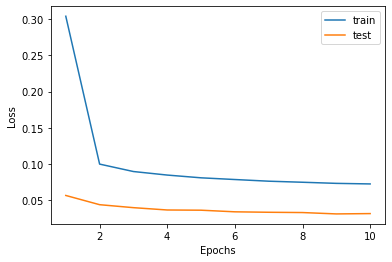

In [61]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [126]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:154]:INFO:starting testing in path: ./out
[lift.py:54]:INFO:total params: 4.27M
[lift.py:60]:INFO:loading ckpt from './out/ckpt_best.pth.tar'
[lift.py:68]:INFO:ckpt loaded (epoch: 2 | err: 0.40371882915496826)


TypeError: ~ (operator.invert) is only implemented on integer and Boolean-type tensors

# Visualize Predictions

In [94]:
from liftpose.postprocess import load_test_results
data = torch.load(par['out_dir'] + "/test_results.pth.tar")
stat_2d, stat_3d = (
    torch.load(par['out_dir'] + "/stat_2d.pth.tar"),
    torch.load(par['out_dir'] + "/stat_3d.pth.tar"),
)
test_3d_gt, test_3d_pred = load_test_results(data, stat_2d, stat_3d)

(37972, 45)


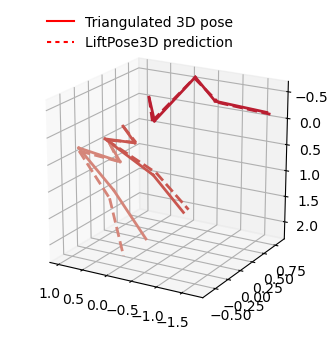

In [100]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=200, azim=60)

t = 900
plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"])